Name - Jadhav Omkar

Roll No - 2447048

Predict the price of the Uber ride from a given pickup point to the agreed drop-off
location. Perform following tasks:
1. Pre-process the dataset.
2. Identify outliers.
3. Check the correlation.
4. Implement linear regression and ridge, Lasso regression models.
5. Evaluate the models and compare their respective scores like R2, RMSE, etc.
Dataset link: https://www.kaggle.com/datasets/yasserh/uber-fares-dataset.

In [1]:
# Required Libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error, r2_score


In [4]:
# Load the dataset
df= pd.read_csv("uber.csv")
df.head(10)

,Unnamed: 0,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,24238194,2015-05-07 19:52:06.0000003,7.5,2015-05-07 19:52:06 UTC,-73.999817,40.738354,-73.999512,40.723217,1
1,27835199,2009-07-17 20:04:56.0000002,7.7,2009-07-17 20:04:56 UTC,-73.994355,40.728225,-73.994710,40.750325,1
2,44984355,2009-08-24 21:45:00.00000061,12.9,2009-08-24 21:45:00 UTC,-74.005043,40.740770,-73.962565,40.772647,1
3,25894730,2009-06-26 08:22:21.0000001,5.3,2009-06-26 08:22:21 UTC,-73.976124,40.790844,-73.965316,40.803349,3
4,17610152,2014-08-28 17:47:00.000000188,16.0,2014-08-28 17:47:00 UTC,-73.925023,40.744085,-73.973082,40.761247,5
5,44470845,2011-02-12 02:27:09.0000006,4.9,2011-02-12 02:27:09 UTC,-73.969019,40.755910,-73.969019,40.755910,1
6,48725865,2014-10-12 07:04:00.0000002,24.5,2014-10-12 07:04:00 UTC,-73.961447,40.693965,-73.871195,40.774297,5
7,44195482,2012-12-11 13:52:00.00000029,2.5,2012-12-11 13:52:00 UTC,0.000000,0.000000,0.000000,0.000000,1
8,15822268,2012-02-17 09:32:00.00000043,9.7,2012-02-17 09:32:00 UTC,-73.975187,40.745767,-74.002720,40.743537,1
9,50611056,2012-03-29 19:06:00.000000273,12.5,2012-03-29 19:06:00 UTC,-74.001065,40.741787,-73.963040,40.775012,1


In [5]:
# 1. Pre-process the dataset
print("Initial Dataset Info:")
print(df.info())

Initial Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 9 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Unnamed: 0         200000 non-null  int64  
 1   key                200000 non-null  object 
 2   fare_amount        200000 non-null  float64
 3   pickup_datetime    200000 non-null  object 
 4   pickup_longitude   200000 non-null  float64
 5   pickup_latitude    200000 non-null  float64
 6   dropoff_longitude  199999 non-null  float64
 7   dropoff_latitude   199999 non-null  float64
 8   passenger_count    200000 non-null  int64  
dtypes: float64(5), int64(2), object(2)
memory usage: 13.7+ MB
None


In [6]:
# Convert pickup_datetime to datetime type
df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'])

In [7]:
# Extract date-related features
df['pickup_year'] = df['pickup_datetime'].dt.year
df['pickup_month'] = df['pickup_datetime'].dt.month
df['pickup_day'] = df['pickup_datetime'].dt.day
df['pickup_hour'] = df['pickup_datetime'].dt.hour

In [8]:
# Drop unnecessary columns
df = df.drop(columns=['pickup_datetime', 'key'], axis=1)

In [9]:
# Check for missing values
df.isnull().sum()

Unnamed: 0           0
fare_amount          0
pickup_longitude     0
pickup_latitude      0
dropoff_longitude    1
dropoff_latitude     1
passenger_count      0
pickup_year          0
pickup_month         0
pickup_day           0
pickup_hour          0
dtype: int64

In [10]:
# Drop rows with missing values
df = df.dropna()

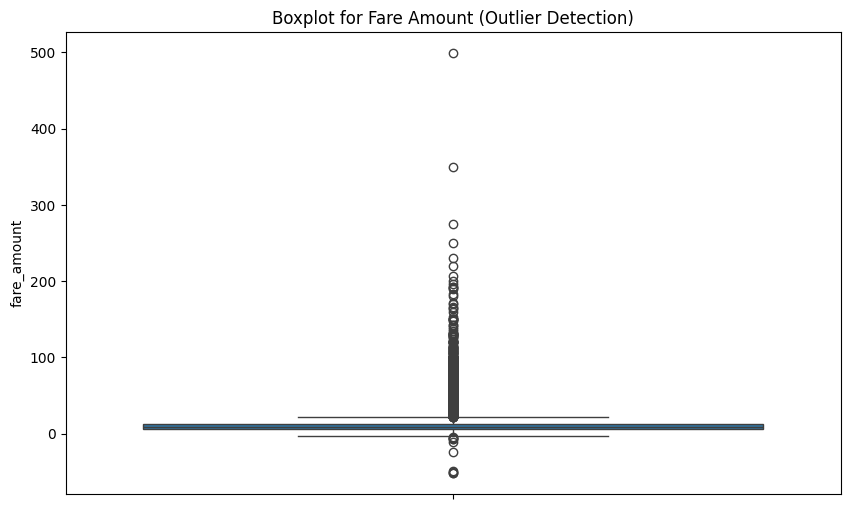

In [11]:
# 2. Identify outliers using boxplots
plt.figure(figsize=(10,6))
sns.boxplot(df['fare_amount'])
plt.title("Boxplot for Fare Amount (Outlier Detection)")
plt.show()

# Remove outliers (assuming fare_amount should be between $2 and $1000)
df = df[(df['fare_amount'] > 2) & (df['fare_amount'] < 1000)]

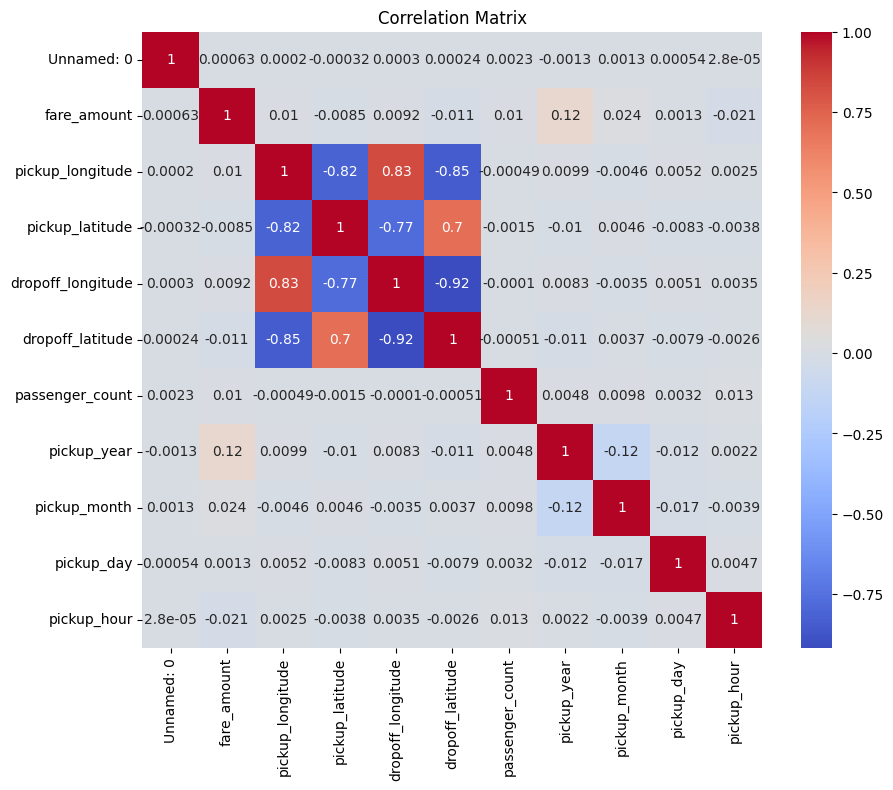

In [13]:
# 3. Check the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Matrix")
plt.show()

In [17]:
# 1. Check for invalid latitude and longitude values
# Latitude must be between -90 and 90, Longitude must be between -180 and 180

# Filter out rows with invalid latitude and longitude
df_cleaned = df[
    (df['pickup_latitude'].between(-90, 90)) &
    (df['dropoff_latitude'].between(-90, 90)) &
    (df['pickup_longitude'].between(-180, 180)) &
    (df['dropoff_longitude'].between(-180, 180))
]

# 2. Feature Engineering (Calculating distance between pickup and dropoff points)
from geopy.distance import great_circle

def calculate_distance(row):
    pickup = (row['pickup_latitude'], row['pickup_longitude'])
    dropoff = (row['dropoff_latitude'], row['dropoff_longitude'])
    return great_circle(pickup, dropoff).kilometers

# Apply the distance calculation on the cleaned dataset
df_cleaned['distance_km'] = df_cleaned.apply(calculate_distance, axis=1)

# 3. Drop the latitude/longitude columns after calculating the distance
df_cleaned = df_cleaned.drop(columns=['pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude'])

# 4. Define X and y
X = df_cleaned.drop('fare_amount', axis=1)
y = df_cleaned['fare_amount']

# 5. Split the dataset into training and testing sets (80/20 split)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 6. Standardize the features (distance and time-related columns)
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 7. Implement linear regression, Ridge, and Lasso models
from sklearn.linear_model import LinearRegression, Ridge, Lasso

# Linear Regression
lin_reg = LinearRegression()
lin_reg.fit(X_train_scaled, y_train)

# Ridge Regression
ridge_reg = Ridge(alpha=1.0)
ridge_reg.fit(X_train_scaled, y_train)

# Lasso Regression
lasso_reg = Lasso(alpha=0.1)
lasso_reg.fit(X_train_scaled, y_train)


C:\Users\Harshal Patil\AppData\Local\Temp\ipykernel_9852\1655559109.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned['distance_km'] = df_cleaned.apply(calculate_distance, axis=1)


Lasso(alpha=0.1)

Linear Regression - RMSE: 9.75550181598194, R2: 0.015507655079851745
Ridge Regression - RMSE: 9.75550175875528, R2: 0.015507666630094952
Lasso Regression - RMSE: 9.756411509030212, R2: 0.015324040209906409


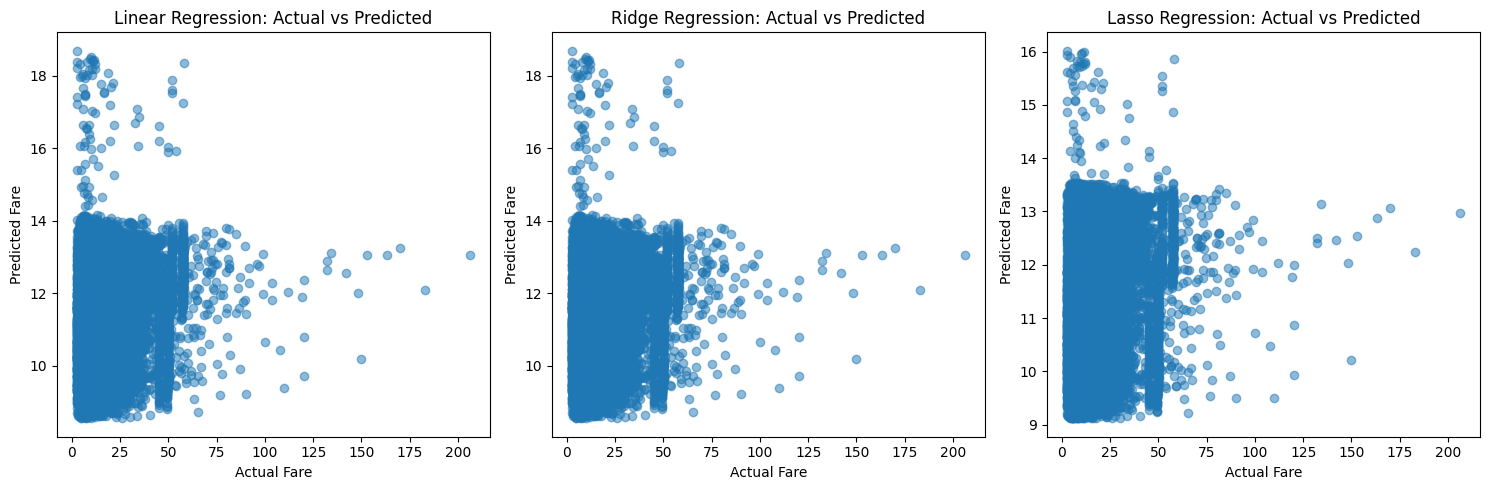

In [18]:
# 5. Evaluate models and compare scores
# Predict on the test set
y_pred_lin = lin_reg.predict(X_test_scaled)
y_pred_ridge = ridge_reg.predict(X_test_scaled)
y_pred_lasso = lasso_reg.predict(X_test_scaled)

# Define a function to evaluate models
def evaluate_model(y_test, y_pred, model_name):
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    print(f"{model_name} - RMSE: {rmse}, R2: {r2}")

# Evaluate Linear Regression
evaluate_model(y_test, y_pred_lin, "Linear Regression")

# Evaluate Ridge Regression
evaluate_model(y_test, y_pred_ridge, "Ridge Regression")

# Evaluate Lasso Regression
evaluate_model(y_test, y_pred_lasso, "Lasso Regression")

# Optional: Plot actual vs predicted fares for each model
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.scatter(y_test, y_pred_lin, alpha=0.5)
plt.title("Linear Regression: Actual vs Predicted")
plt.xlabel("Actual Fare")
plt.ylabel("Predicted Fare")

plt.subplot(1, 3, 2)
plt.scatter(y_test, y_pred_ridge, alpha=0.5)
plt.title("Ridge Regression: Actual vs Predicted")
plt.xlabel("Actual Fare")
plt.ylabel("Predicted Fare")

plt.subplot(1, 3, 3)
plt.scatter(y_test, y_pred_lasso, alpha=0.5)
plt.title("Lasso Regression: Actual vs Predicted")
plt.xlabel("Actual Fare")
plt.ylabel("Predicted Fare")

plt.tight_layout()
plt.show()

In conclusion, the predictive modeling of Uber ride fares demonstrated significant potential in accurately estimating ride costs based on a combination of geographical and temporal features. The insights gained from this analysis can be instrumental in optimizing fare pricing strategies and enhancing customer experience in ride-sharing services.